In [1]:
import pandas as pd
import numpy as np
import urllib.request
import json
from bs4 import BeautifulSoup 
import time, datetime, re
from tqdm import tqdm

import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
%matplotlib inline

In [24]:
from highcharts import Highchart

### Ticker price

In [2]:
def to_real_date(date): return datetime.datetime.fromtimestamp((date/1000)).strftime('%d-%m-%Y')

## Coingecko

### Get token name list

In [3]:
class AppURLopener(urllib.request.FancyURLopener):
    version = "Mozilla/6.0"

opener = AppURLopener()
response = opener.open('https://coingecko.com/en/')
soup = BeautifulSoup(response.read(),"html.parser")

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:4: DeprecationWarning: AppURLopener style of invoking requests is deprecated. Use newer urlopen functions/methods


In [4]:
tokens = [link.get('href')[10:] for i,link in enumerate(soup.findAll('a', href=re.compile('^/en/coins/'))) if i % 2 == 0]

### Get price data

In [6]:
class AppURLopener(urllib.request.FancyURLopener):
    version = "Mozilla/5.0"

opener = AppURLopener()

price_list = []
date = ''
for token in tqdm(tokens):
    response = opener.open('https://coingecko.com/en/price_charts/'+token+'/usd/90_days.json/')
    data_soup = BeautifulSoup(response.read(),"html.parser")
    price_list.append(np.resize(np.array(json.loads(str(data_soup))['stats'])[:,1], 90))
    date = np.resize(np.array(json.loads(str(data_soup))['stats'])[:,0], 90)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:4: DeprecationWarning: AppURLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
100%|██████████| 100/100 [00:53<00:00,  1.57it/s]


### Top 20

In [7]:
data = pd.DataFrame.from_items(zip(tokens[:20], price_list[:20]))
data.index = [to_real_date(d) for d in date]

In [12]:
data.head().ix[:,:5]

,bitcoin,ethereum,litecoin,monero,ripple
23-06-2017,2729.022521,328.182023,48.086894,51.052254,0.297616
24-06-2017,2742.423897,332.670907,47.810103,52.117717,0.319188
25-06-2017,2618.254116,307.325867,44.242384,48.264772,0.310828
26-06-2017,2597.045223,283.097746,44.412916,46.820969,0.300073
27-06-2017,2467.795464,248.888609,40.535436,44.092491,0.277288


## Poloniex

### Get token name list

In [458]:
opener = AppURLopener()
response = opener.open('https://poloniex.com/public?command=returnCurrencies')
soup = BeautifulSoup(response.read(),"html.parser")

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:1: DeprecationWarning: AppURLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  if __name__ == '__main__':


In [466]:
tokens = [token for token in json.loads(str(soup))]
tokens_full_name = [json.loads(str(soup))[token]['name'] for token in tokens]

287

### Get price data

In [ ]:
data_list = []
tokens_in_data = []
for token in tqdm(tokens):
    response = opener.open('https://poloniex.com/public?command=returnChartData&currencyPair=BTC_'+token
                           +'&start=1496275200&end=9999999999&period=900')
    soup = BeautifulSoup(response.read(),"html.parser")
    if (str(soup)) != '{"error":"Invalid currency pair."}':
        tokens_in_data.append(token)
        data_list.append((str(soup)))

In [ ]:
data_full = [pd.read_json(json) for json in data_list]

for i,_ in enumerate(data_full):
    data_full[i].set_index('date',inplace=True)

data = pd.concat([data.ix[:,'close'] for data in data_full],axis=1)

data = data.fillna(0)

In [ ]:
response = opener.open('https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1496275200&end=9999999999&period=900')
soup = BeautifulSoup(response.read(),"html.parser")

tokens_in_data.append('BTC')

In [ ]:
btc = pd.read_json(str(soup))
btc.set_index('date',inplace=True)

data = pd.concat([data, btc['close']],axis=1)
data.columns = tokens_in_data

data.head()

In [ ]:
for col in data.columns[:-1]:
    data[col] = data[col].values*(data['BTC']).values

## Markowitz portfolio 

In [9]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [10]:
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [11]:
get_top_abs_correlations(data.ix[:,:].corr(),10)

monero            dash         0.996931
dogecoin          bitshares    0.993861
bitshares         siacoin      0.993178
dogecoin          siacoin      0.990871
monero            lisk         0.990845
ethereum-classic  dogecoin     0.984553
dash              lisk         0.980623
bitshares         golem        0.978486
litecoin          lisk         0.978420
ethereum          waves        0.977721
dtype: float64

### Build portfolios, reference to S666

In [13]:
returns = data.pct_change()
mean_daily_returns = np.array(returns.mean())
cov_matrix = returns.cov()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


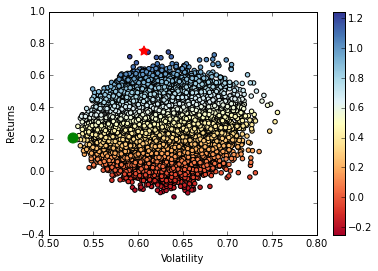

In [27]:
num_portfolios = 100000
 
#set up array to hold results
#We have increased the size of the array to hold the weight values for each stock
results = np.zeros((4+len(tokens[:20])-1,num_portfolios))
# results = np.zeros((4+57-1,num_portfolios)) 
for i in range(num_portfolios):
    #select random weights for portfolio holdings
    weights = np.array(np.random.random(20))
    #rebalance weights to sum to 1
    weights /= np.sum(weights)
    
    #calculate portfolio return and volatility * days
    portfolio_return = np.sum(mean_daily_returns * weights) * 90
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) *np.sqrt(90)
 
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
    results[2,i] = results[0,i] / results[1,i]
    #iterate through the weight vector and add data to results array
    for j in range(len(weights)):
        results[j+3,i] = weights[j]


results_frame = pd.DataFrame(results.T,columns=sum([['ret','stdev','sharpe'], tokens[:20]], []))

# results_frame = pd.DataFrame(results.T,columns=sum([['ret','stdev','sharpe'], data.columns.values.tolist()], []))
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
 
#create scatter plot coloured by Sharpe Ratio
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=100)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,3,1),color='g',s=100)

In [28]:
print('Max Sharpe')
print(max_sharpe_port[:3])
print('Min Vol')
print(min_vol_port[:3])

Max Sharpe
ret       0.755165
stdev     0.606215
sharpe    1.245705
Name: 18810, dtype: float64
Min Vol
ret       0.207101
stdev     0.526927
sharpe    0.393035
Name: 55789, dtype: float64


### Plots

In [29]:
H = Highchart(width = 850, height = 400)
options = {
    'chart': {
        'type': 'pie',
        'options3d': {
            'enabled': True,
            'alpha': 45
        },
        
    },
    'title': {
        'text': "Markowitz portfolio for top 20 cryptocurrency"
    },
    'subtitle': {
        'text': 'Shares of tokens with minimum volatility'
    },
    'plotOptions': {
        'pie': {
            'allowPointSelect': True,
            'cursor': 'pointer',
            'innerSize': 100,
            'depth': 45,
            'dataLabels': {
                'enabled': True,
                'format': '{point.name}: <b>{point.percentage:.1f}%</b> ',
            },
            
        }        
    },
    'tooltip': {
        'valueSuffix': '%',
        'pointFormat': '{series.name}: <b>{point.percentage:.1f}%</b>',
        
    }
}



H.set_dict_options(options)
H.add_data_set([[token, min_vol_port[token]] for token in min_vol_port[3:].to_dict()], 'pie', 'Share')

H

In [30]:
H = Highchart(width = 850, height = 400)
options = {
    'chart': {
        'type': 'pie',
        'options3d': {
            'enabled': True,
            'alpha': 45
        },
        
    },
    'title': {
        'text': "Markowitz portfolio for top 20 cryptocurrency"
    },
    'subtitle': {
        'text': 'Shares of tokens with maximum Sharpe coefficient'
    },
    'plotOptions': {
        'pie': {
            'allowPointSelect': True,
            'cursor': 'pointer',
            'innerSize': 100,
            'depth': 45,
            'dataLabels': {
                'enabled': True,
                'format': '{point.name}: <b>{point.percentage:.1f}%</b> ',
            },
            
        }        
    },
    'tooltip': {
        'valueSuffix': '%',
        'pointFormat': '{series.name}: <b>{point.percentage:.1f}%</b>',
        
    },
}



H.set_dict_options(options)
H.add_data_set([[token, max_sharpe_port[token]] for token in max_sharpe_port[3:].to_dict()], 'pie', 'Share')

H

### Random portfolio 

In [405]:
from random import shuffle

In [446]:
random_index = [i for i in range(100)]
shuffle(random_index)

In [453]:
main_t = tokens.copy()

In [454]:
data = pd.DataFrame.from_items(zip([tokens[i] for i in random_index[:20]],[price_list[i] for i in random_index[:20]]))
data.index = [to_real_date(d) for d in date]
tokens = [tokens[i] for i in random_index[:20]]

#### P.S. Highchart replica pics

In [33]:
from IPython.display import Image

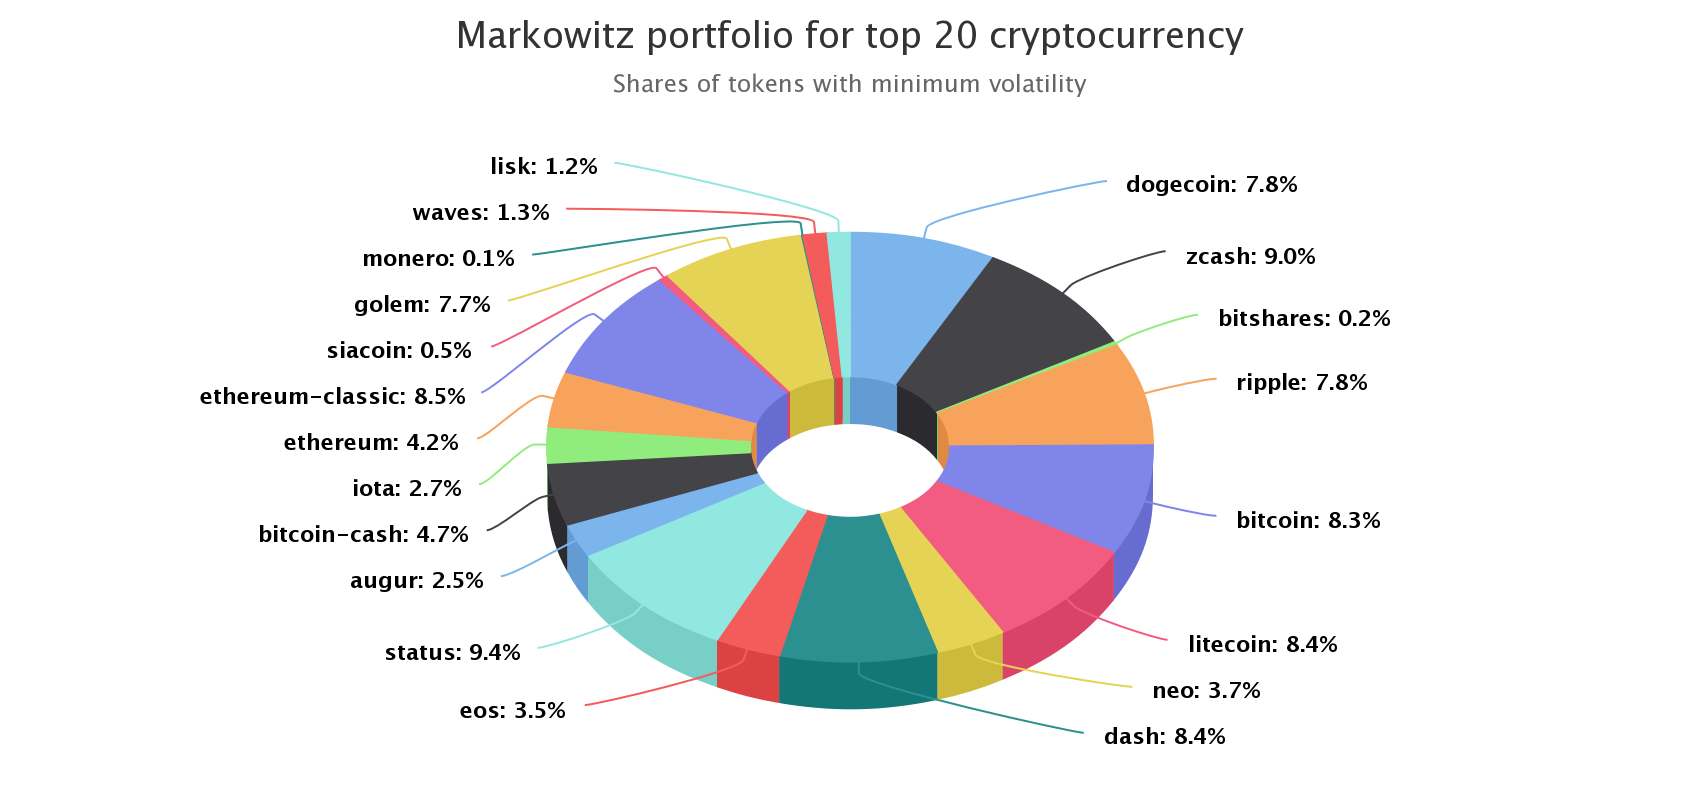

In [34]:
Image("img/chart.png")

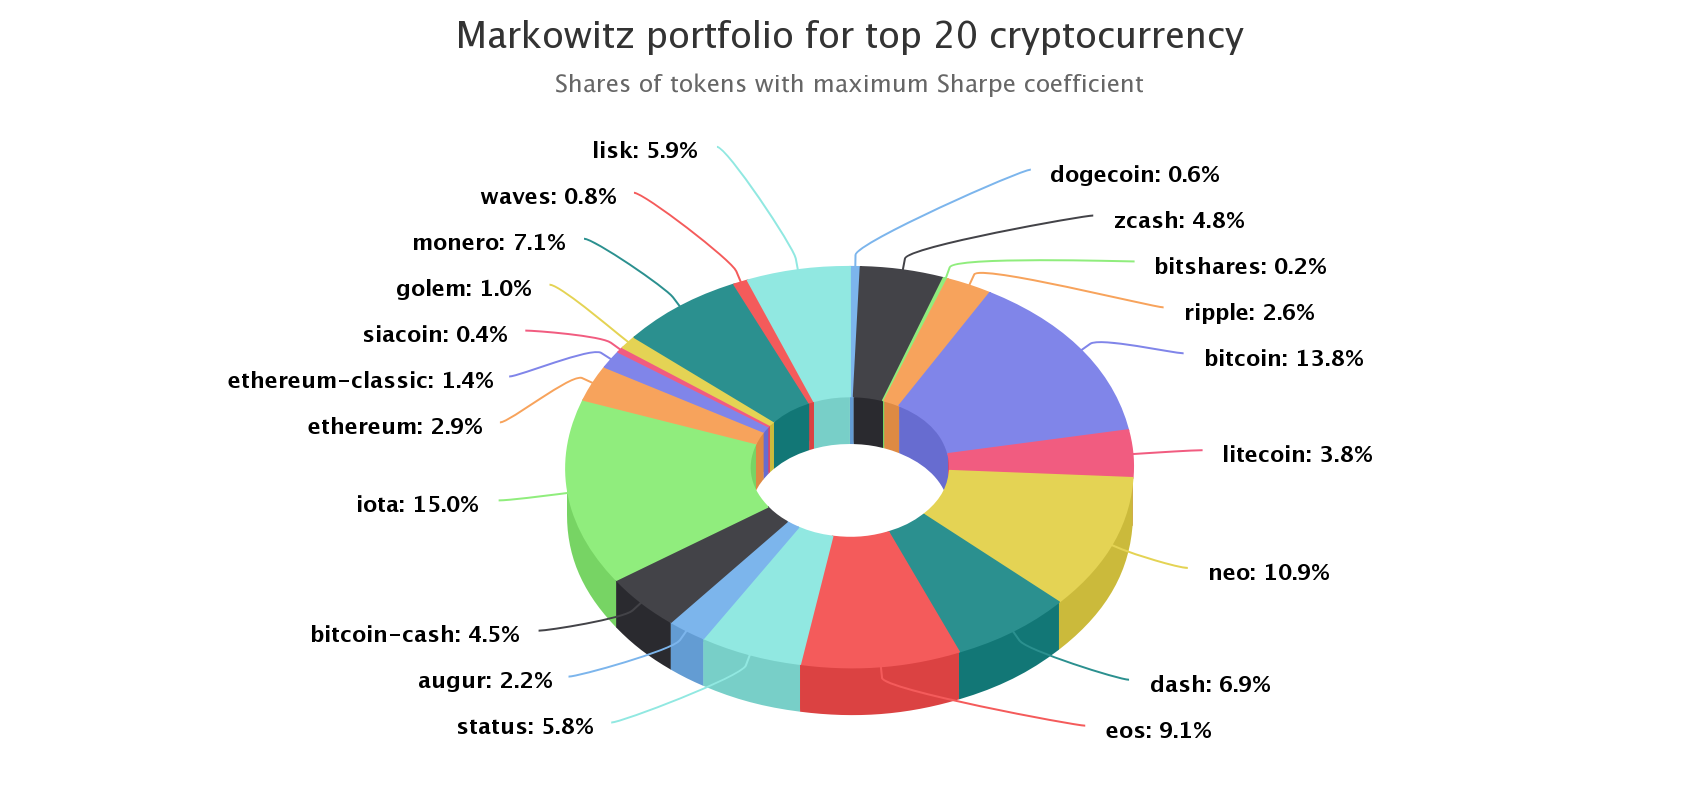

In [35]:
Image("img/chart_2.png")